In [ ]:
% matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm

import numpy as np
from numpy import ma

import scipy 
from scipy import linalg as la
import glob, os, psutil, time

from pykalman import KalmanFilter
from subtracking import Grouse, calc_subspace_proj_error
from ssidid.SSID_Hankel_loss import run_bad, plot_slim, print_slim, f_l2_Hankel_nl, f_l2_Hankel_comp_Q_Om
from ssidid import ObservationScheme, progprint_xrange
from ssidid.utility import get_subpop_stats, gen_data, draw_data
from ssidid.icml_scripts import run_default


lag_range = np.arange(11)
kl_ = np.max(lag_range) + 1
snr = (1.0, 1.0)
p,n,T = 200, 3, 20000 + kl_
mmap, verbose = False, False

def principal_angle(A, B):
    "A and B must be column-orthogonal."    
    A = np.atleast_2d(A).T if (A.ndim<2) else A
    B = np.atleast_2d(B).T if (B.ndim<2) else B
    A = la.orth(A)
    B = la.orth(B)
    svd = la.svd(A.T.dot(B))
    return np.arccos(np.minimum(svd[1], 1.0)) / (np.pi/2)

data_path =  '/home/mackelab/Desktop/Projects/Stitching/results/'
idx_a, idx_b = np.arange(p), np.arange(p)

#np.random.seed(rnd_seed)
#pars_true, x, y, _, _ = gen_data(p,n,lag_range,T, nr,
#                                 eig_m_r, eig_M_r, 
#                                 eig_m_c, eig_M_c,
#                                 mmap, chunksize,
#                                 data_path,
#                                 snr=snr, whiten=whiten)    

th = np.pi/20
pars_true = {
    #'C' : np.array([[-0.25, 0.75],
    #                [ 0.6 , 0.4 ],
    #                [ 0.5 , 0.01], 
    #                [-0.1 ,-0.9 ],
    #                [ 0.7 ,-0.3 ]]),
    'C' : np.random.normal(size=(p,n)) / np.sqrt(n), 
    'A' : np.array([[0.999999 * np.cos(th),  0.999999 * np.sin(th), 0 ], 
                    [-0.999999 * np.sin(th), 0.999999 * np.cos(th), 0 ], 
                    [0.,                  0.,                 0.9]]), 
    'Q' : np.diag((2e-15, 2e-6, 2e-1)),
    'V0' : 0.1 * np.eye(n),
    'mu0': np.array([1,0,0])
}
pars_true['Pi'] = np.atleast_2d(scipy.linalg.solve_discrete_lyapunov(pars_true['A'], pars_true['Q']))
NSR = np.random.uniform(size=p, low=snr[0], high=snr[1]) # 1/SNR
pars_true['C'] /= np.atleast_2d(np.sqrt(np.sum(pars_true['C']*pars_true['C'].dot(pars_true['Pi']), axis=1) * (1 + NSR))).T
pars_true['C'] /= np.atleast_2d(np.sqrt(np.sum(pars_true['C']*pars_true['C'].dot(pars_true['Pi']), axis=1) * (1 + NSR))).T
pars_true['R'] = np.sum(pars_true['C']*pars_true['C'].dot(pars_true['Pi']), axis=1) * NSR


rnd_seed = np.mod(int(time.time() * 10000), 10000)
np.random.seed(rnd_seed)
x, y = draw_data(pars_true, 2*T)
x, y = x[T:,:], y[T:,:]
y -= y.mean(axis=0)
#y /= np.sqrt(np.var(y, axis=0).reshape(1,p))

save_dict = {'p' : p,
             'n' : n,
             'T' : T,
             'snr' : snr,
             'obs_scheme' : None,
             'lag_range' : lag_range,
             'x' : x,
             'mmap' : mmap,
             'y' : data_path if mmap else y,
             'pars_true' : pars_true,
             'pars_est' : None,
             'idx_a' : np.arange(p),
             'idx_b' : np.arange(p),
             'W' : None,
             'Qs' : None,
             'Om' : None,
             'rnd_seed' : rnd_seed}

file_name = 'p' + str(p) + 'n' + str(n) + 'T' + str(T) + 'snr' + str(np.int(np.mean(snr)//1))
np.savez(data_path + file_name, save_dict)    

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(pars_true['C'], interpolation='None')
plt.colorbar()

plt.subplot(2,2,2)
plt.plot(x[:,0], x[:,1])

plot_range = np.arange(-500,500) + T//2
plt.subplot(2,2,4)
plt.plot(x[plot_range,:])
plt.show()

print('var[x]', np.var(x, axis=0))

#switch_time = 300
#plot_range = obs_scheme.obs_time[0] + np.arange(-switch_time, switch_time)
#plt.plot(x[plot_range,0], x[plot_range,1])


In [ ]:
pars_true['Pi']

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111, projection='3d')

ax.plot(x[:,0], x[:,1], x[:,2])
ax.view_init(80,30)
plt.show()

In [ ]:
# full populations fit

sub_pops = (np.arange(p//2+1),np.arange(p//2-1,p))
reps = 1
obs_pops = np.concatenate([ np.arange(len(sub_pops)) for r in range(reps) ])
obs_time = np.linspace(0,T, len(obs_pops)+1)[1:].astype(int)
obs_scheme = ObservationScheme(p=p, T=T, 
                                sub_pops=sub_pops, 
                                obs_pops=obs_pops, 
                                obs_time=obs_time)
obs_scheme.comp_subpop_stats()    
sub_pops = obs_scheme.sub_pops
W = obs_scheme.comp_coocurrence_weights(lag_range, sso=True, idx_a=idx_a, idx_b=idx_b)
for m in range(len(lag_range)):
    W[m][0,1] = 0.
    W[m][1,0] = 0.
idx_a, idx_b = np.arange(p), np.arange(p)
print('re-computing observed covariance matrices')    
Qs, Om = f_l2_Hankel_comp_Q_Om(n=n,y=y,lag_range=lag_range,obs_scheme=obs_scheme,
                      idx_a=idx_a,idx_b=idx_b,W=W,sso=True,
                      mmap=mmap,data_path=data_path,ts=None,ms=None)
for m in range(len(lag_range)):
    Om[m][np.ix_(obs_scheme.idx_grp[0], obs_scheme.idx_grp[1])] = False
    Om[m][np.ix_(obs_scheme.idx_grp[1], obs_scheme.idx_grp[0])] = False

rnd_seed = np.random.get_state()
pars_est, traces, ts= run_default(
            alphas    = (0.05, 0.005), 
            b1s       = (0.98, 0.95), 
            a_decays  = (0.98, 0.98), 
            batch_sizes = (1, 10), 
            max_zip_sizes =  (100,100), 
            max_iters = (200, 200),
            parametrizations = ('nl', 'nl'),
            pars_est='default', pars_true=pars_true, n=n, 
            y=y, sso=True, obs_scheme=obs_scheme, lag_range=lag_range, 
            idx_a=idx_a, idx_b=idx_b,Qs=Qs,Om=Om, W=W,
            traces=[[], [], []], ts = [], verbose=verbose)    

print('per-subpops principal angles')
C, sub_pops = pars_est['C'].copy(), obs_scheme.sub_pops
print(principal_angle(pars_true['C'][sub_pops[0],:], C[sub_pops[0],:]))
print(principal_angle(pars_true['C'][sub_pops[1],:], C[sub_pops[1],:]))


# first subpopulation

sp = obs_scheme.sub_pops[0].copy()
ysp = y[:,sp]
ysp -= ysp.mean(axis=0)
idx_a, idx_b = np.arange(len(sp)), np.arange(len(sp))

sub_pops = (np.arange(len(sp)), np.array([]))
obs_scheme1 = ObservationScheme(p=len(sp), T=T, 
                                sub_pops=sub_pops, 
                                obs_pops=obs_pops, 
                                obs_time=obs_time)
obs_scheme1.comp_subpop_stats()    
print('re-computing observed covariance matrices')    
W = obs_scheme1.comp_coocurrence_weights(lag_range, sso=True, idx_a=idx_a, idx_b=idx_b)
Qs, Om = f_l2_Hankel_comp_Q_Om(n=n,y=ysp,lag_range=lag_range,obs_scheme=obs_scheme1,
                      idx_a=idx_a,idx_b=idx_b,W=W,sso=True,
                      mmap=mmap,data_path=data_path,ts=None,ms=None)

pars_est_1, traces_1, ts_1 = run_default(
            alphas    = (0.05, 0.005), 
            b1s       = (0.98, 0.95), 
            a_decays  = (0.98, 0.98), 
            batch_sizes = (1, 10), 
            max_zip_sizes =  (100,100), 
            max_iters = (200, 200),
            parametrizations = ('nl', 'ln'),
            pars_est='default', 
            pars_true={'A' : pars_true['A'],
                       'Pi': pars_true['Pi'],
                       'C' : pars_true['C'][sp,:],
                       'R' : pars_true['R'][sp]},
            n=n, 
            y=ysp, sso=True, obs_scheme=obs_scheme1, lag_range=lag_range, 
            idx_a=idx_a, idx_b=idx_b,Qs=Qs,Om=Om, W=W,
            traces=[[], [], []], ts = [], verbose=verbose)    


# second subpopulation

sp =  obs_scheme.sub_pops[1].copy()
ysp = y[:,sp]
ysp -= ysp.mean(axis=0)
idx_a, idx_b = np.arange(len(sp)), np.arange(len(sp))

sub_pops = (np.array([]), np.arange(len(sp)))
obs_scheme2 = ObservationScheme(p=len(sp), T=T, 
                                sub_pops=sub_pops, 
                                obs_pops=obs_pops, 
                                obs_time=obs_time)
obs_scheme.comp_subpop_stats()    
print('re-computing observed covariance matrices')    
W = obs_scheme2.comp_coocurrence_weights(lag_range, sso=True, idx_a=idx_a, idx_b=idx_b)
Qs, Om = f_l2_Hankel_comp_Q_Om(n=n,y=ysp,lag_range=lag_range,obs_scheme=obs_scheme2,
                      idx_a=idx_a,idx_b=idx_b,W=W,sso=True,
                      mmap=mmap,data_path=data_path,ts=None,ms=None)

pars_est_2, traces_2, ts_2 = run_default(
            alphas    = (0.05, 0.005), 
            b1s       = (0.98, 0.95), 
            a_decays  = (0.98, 0.98), 
            batch_sizes = (1, 10), 
            max_zip_sizes =  (100,100), 
            max_iters = (200, 200),
            parametrizations = ('nl', 'ln'),
            pars_est='default', 
            pars_true={'A' : pars_true['A'],
                       'Pi': pars_true['Pi'],
                       'C' : pars_true['C'][sp,:],
                       'R' : pars_true['R'][sp]},
            n=n, 
            y=ysp, sso=True, obs_scheme=obs_scheme2, lag_range=lag_range, 
            idx_a=idx_a, idx_b=idx_b,Qs=Qs,Om=Om, W=W,
            traces=[[], [], []], ts = [], verbose=verbose)    


save_dict = {'p' : p,
             'n' : n,
             'T' : T,
             'snr' : snr,
             'obs_scheme' : obs_scheme,
             'obs_scheme1' : obs_scheme1,
             'obs_scheme2' : obs_scheme2,
             'lag_range' : lag_range,
             'x' : x,
             'mmap' : mmap,
             'sso' : True,
             'verbose' : False,
             'y' : y,
             'pars_true' : pars_true,
             'pars_est' : pars_est,
             'pars_est_1' : pars_est_1,
             'pars_est_2' : pars_est_2,             
             'traces' : traces,
             'traces_1' : traces_1,
             'traces_2' : traces_2,
             'ts' : ts,
             'ts_1' : ts_1,
             'ts_2' : ts_2,
             'idx_a' : np.arange(p),
             'idx_b' : np.arange(p),
             'W' : None,
             'Qs' : None,
             'Om' : None,
             'rnd_seed' : rnd_seed}

file_name = 'p' + str(p) + 'n' + str(n) + 'T' + str(T) + 'snr' + str(np.int(np.mean(snr)//1))
np.savez(data_path + file_name, save_dict)    

# load results and apply Kalman filter with learned params. to traces

In [1]:
#% matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm

import numpy as np
from numpy import ma

import scipy 
from scipy import linalg as la
import glob, os, psutil, time

from pykalman import KalmanFilter
from subtracking import Grouse, calc_subspace_proj_error
from ssidid.SSID_Hankel_loss import run_bad, plot_slim, print_slim, f_l2_Hankel_nl, f_l2_Hankel_comp_Q_Om
from ssidid import ObservationScheme, progprint_xrange
from ssidid.utility import get_subpop_stats, gen_data, draw_data
from ssidid.icml_scripts import run_default

from mpl_toolkits.mplot3d import Axes3D

try:
    snr[0]
except:
    lag_range = np.arange(11)
    kl_ = np.max(lag_range) + 1
    snr = (0.3, 0.3)
    p,n,T = 20, 3, 20000 + kl_

data_path =  '/home/mackelab/Desktop/Projects/Stitching/results/'
file_name = 'p' + str(p) + 'n' + str(n) + 'T' + str(T) + 'snr' + str(np.int(np.mean(snr)//1))
lf = np.load(data_path + file_name + '.npz')['arr_0'].tolist()

p, n, T, snr, x, y, lag_range = lf['p'],lf['n'],lf['T'],lf['snr'],lf['x'],lf['y'],lf['lag_range']
mmap, sso, verbose, rnd_seed  = lf['mmap'],lf['sso'],lf['verbose'],lf['rnd_seed']
obs_scheme, obs_scheme1, obs_scheme2 = lf['obs_scheme'],lf['obs_scheme1'],lf['obs_scheme2']
pars_est,pars_est_1,pars_est_2 = lf['pars_est'], lf['pars_est_1'], lf['pars_est_2']
pars_true, idx_a, idx_b = lf['pars_true'], lf['idx_a'], lf['idx_b']

plt.figure(figsize=(20,16))

for j in range(n):
    plt.subplot(n,1,j)
    plt.plot(x[:,j], 'k', linewidth=3)
    plt.hold(True)
    #plt.axis([0, T+1, -2.5, 2.5])
               
obs_scheme.gen_mask_from_scheme()

clrs = ['g', 'c', 'r', 'm']


smoothed_state_means = [np.zeros(n)]
x_est = np.zeros((0,n))
for ti in range(len(obs_scheme.obs_time)):
    i = obs_scheme.obs_pops[ti]
    if len(obs_scheme.sub_pops[i]) > 0:
        kf = KalmanFilter(transition_matrices = pars_est['A'], 
                          observation_matrices = pars_est['C'][obs_scheme.sub_pops[i],:],
                          observation_covariance = np.diag(pars_true['R'][obs_scheme.sub_pops[i]]), 
                          initial_state_mean=smoothed_state_means[-1]
                         )
        start, end = 0 if ti==0 else obs_scheme.obs_time[ti-1], obs_scheme.obs_time[ti]
        tsi = np.arange(start, end)
        measurements = ma.asarray(y[np.ix_(tsi,obs_scheme.sub_pops[i])])
        measurements[np.invert(obs_scheme.mask[np.ix_(tsi,obs_scheme.sub_pops[i])])] = ma.masked   # measurement at timestep 1 is unobserved

        (filtered_state_means, filtered_state_covariances) = kf.filter(measurements)
        (smoothed_state_means, smoothed_state_covariances) = kf.smooth(measurements)
        x_est = np.vstack((x_est, smoothed_state_means))

        for j in range(n):
            plt.subplot(n,1,j)
            plt.plot(tsi,smoothed_state_means[:,j], color=clrs[0], linewidth=1.5)
            plt.plot([end, end], [-10, 10], 'k-')
#plt.axis([0, T+1, -5, 5])


parss = [pars_est_1, pars_est_2]
schemes = [obs_scheme1, obs_scheme2]
ys = [y[:,np.arange(2)], y[:,np.arange(1,3)]]
x_est12 = np.zeros((0,n))

smoothed_state_means = [np.zeros(n)]
for ti in range(len(obs_scheme.obs_time)):
    i = obs_scheme.obs_pops[ti]
    pars = parss[i]
    if len(obs_scheme.sub_pops[i]) > 0:
        kf = KalmanFilter(transition_matrices = pars['A'], 
                          observation_matrices = pars['C'][schemes[i].sub_pops[i],:],
                          observation_covariance = np.diag(pars_true['R'][schemes[i].sub_pops[i]]), 
                          initial_state_mean=smoothed_state_means[-1]
                         )
        start, end = 0 if ti==0 else obs_scheme.obs_time[ti-1], obs_scheme.obs_time[ti]
        tsi = np.arange(start, end)
        measurements = ma.asarray(y[np.ix_(tsi,obs_scheme.sub_pops[i])])
        measurements[np.invert(obs_scheme.mask[np.ix_(tsi,obs_scheme.sub_pops[i])])] = ma.masked   # measurement at timestep 1 is unobserved

        (filtered_state_means, filtered_state_covariances) = kf.filter(measurements)
        (smoothed_state_means, smoothed_state_covariances) = kf.smooth(measurements)
        x_est12 = np.vstack((x_est12, smoothed_state_means))


        for j in range(n):
            plt.subplot(n,1,j)
            plt.plot(tsi,smoothed_state_means[:,j], '-', color=clrs[2], linewidth=1.5)
               
plt.show()

/home/mackelab/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_subplots.py:69: MatplotlibDeprecationWarning: The use of 0 (which ends up being the _last_ sub-plot) is deprecated in 1.4 and will raise an error in 1.5
  mplDeprecation)


In [ ]:
#%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(14,6))


color_stitch = (244/255, 152/255, 25/255)
color_sp1    = 'g' #(0, 174/255,239/255)
color_sp2    = 'c' #(0, 174/255,239/255)


marker = '.-'
x -= x.mean(axis=0)
x_est12 -= x_est12.mean(axis=0)

switch_time = 300
plot_range = np.arange(-switch_time, switch_time) + obs_scheme.obs_time[0]
#plot_range = np.hstack((np.random.choice(obs_scheme.obs_time[0], 
#                                         switch_time, 
#                                         replace=False),
#                        np.random.choice(T-obs_scheme.obs_time[0], 
#                                         switch_time, 
#                                         replace=False) + obs_scheme.obs_time[0]))

rot12 = np.linalg.lstsq(x_est12[:obs_scheme.obs_time[0],:], x[:obs_scheme.obs_time[0],:])[0]
rot = np.linalg.lstsq(x_est[:obs_scheme.obs_time[0],:], x[:obs_scheme.obs_time[0],:])[0]
rot21 = np.linalg.lstsq(x_est12[obs_scheme.obs_time[0]:,:], x[obs_scheme.obs_time[0]:,:])[0]


angle1, angle2 = 90, 30

ax = fig.add_subplot(131, projection='3d')
tmp = x[plot_range,:]
ax.plot(tmp[:,0], 
        tmp[:,1], 
        tmp[:,2], 
        marker,
        linewidth=2,
        color = 'k')
#ax.plot([0,0],
#        [0,0],
#        [-3,3], 
#        linewidth=2.5, 
#        color='k')

ax.view_init(angle1, angle2)
plt.title('ground truth')
plt.axis([-2,2,-2,2])
plt.xticks([-1, 0, 1])
plt.yticks([-1, 0, 1])


ax = fig.add_subplot(132, projection='3d')
tmp = x_est[plot_range,:].dot(rot)
ax.plot(tmp[:,0], 
        tmp[:,1], 
        tmp[:,2], 
        marker,
        linewidth=2,
        color = color_stitch)

#ax.plot([0,0],
#        [0,0],
#        [-3,3], 
#        linewidth=2.5, 
#        color=color_stitch)
ax.view_init(angle1, angle2)
plt.title('estimate from full population')
plt.axis([-2,2,-2,2])
plt.xticks([-1, 0, 1])
plt.yticks([-1, 0, 1])


ax = fig.add_subplot(133, projection='3d')
tmp = x_est12[plot_range,:].dot(rot12)
ax.plot(tmp[:switch_time,0], 
        tmp[:switch_time,1], 
        tmp[:switch_time,2], 
        marker,
        linewidth=2,
        color = color_sp1,
        alpha=0.7)
ax.plot(tmp[switch_time:,0], 
        tmp[switch_time:,1], 
        tmp[switch_time:,2], 
        marker,
        linewidth=2,
        color = color_sp2,
        alpha =0.7)
plt.title('estimates from subpopulations')
plt.axis([-2,2,-2,2])
plt.xticks([-1, 0, 1])
plt.yticks([-1, 0, 1])

#ax.plot([0,0],
#        [0,0],
#        [-3,3], 
#        linewidth=2.5, 
#        color=color_sp1)

ax.view_init(angle1, angle2)

plt.savefig(fig_path + 'state_spaces_3d.pdf')

plt.show()

In [ ]:
plt.figure(figsize=(10,6))

switch_time = 500

y_est   = np.zeros_like(y)
y_est12 = np.zeros_like(y)

idx_t = np.arange(y.shape[0]) #np.arange(obs_scheme.obs_time[0], dtype=int)
idx_i = np.setdiff1d(np.arange(p), obs_scheme.sub_pops[0])
idx = np.ix_(idx_t, idx_i)

y_est[idx] =   x_est[idx_t,:].dot(pars_est['C'][idx_i,:].T)
y_est12[idx] = x_est12[idx_t,:].dot(parss[1]['C'][2:,:].T)

idx_t = np.arange(y.shape[0]) #np.arange(obs_scheme.obs_time[0],y.shape[0]), dtype=int)
idx_i = np.setdiff1d(np.arange(p), obs_scheme.sub_pops[1])
idx = np.ix_(idx_t, idx_i)
y_est[idx] =   x_est[idx_t,:].dot(pars_est['C'][idx_i,:].T)
y_est12[idx] = x_est12[idx_t,:].dot(parss[0]['C'][:-2,:].T)

# select neurons for plotting
plot_idx_i = [[3,12,13], [3,12,13], [19,24,29], [19,24,29]]

dy = 6
for j in range(4):
    
    facecolor = 'g' if np.mod(j,2)==0 else 'c'
    color_sp  = color_sp1 if j < 2 else color_sp2    
    lw = 2 if j in [0,3] else 1.
    plot_range = np.arange(-switch_time, -0) if np.mod(j,2)==0 else np.arange(0, switch_time)
    plot_range += obs_scheme.obs_time[0]
    
    for k in range(len(plot_idx_i[j])):    
        offset = (len(plot_idx_i[j])-1-k)*dy
        if j < 2: 
            offset += 3 * dy 
        plt.plot(plot_range, y[plot_range,plot_idx_i[j][k]] + offset,       color=np.array((200,200,200))/255, linewidth=0.9)
        plt.plot(plot_range, y_est[plot_range,plot_idx_i[j][k]] + offset,   color=color_stitch,                linewidth=lw)
        plt.plot(plot_range, y_est12[plot_range,plot_idx_i[j][k]] + offset, color=color_sp,                    linewidth=1)
        plt.hold(True)
    y_max, y_min = dy * (len(plot_idx_i[j])-1) + 3, -3
    
#plt.fill_between([plot_range[0], plot_range[1]],
#                 [y_min, y_min],
#                 [y_max, y_max],
#                 facecolor=facecolor, alpha=0.15)

plt.xticks([9750, 10000, 10250], [-250, 0, 250])
#plt.axis([0, len(plot_range), y_min, y_max])
plt.tick_params(axis="both", which="both", top="off", right="off", labelleft="on", tickdir='out')    
plt.box('off')

plt.xlabel('time relative to switch-point')
plt.ylabel('#neuron')

plot_idx_is = plot_idx_i[1] + plot_idx_i[2]
plt.yticks(np.arange(len(plot_idx_is))[::-1] * dy, plot_idx_is)
    
plt.savefig(fig_path + 'predictions__transition_n3_oscillator.pdf')    
plt.show()


In [ ]:
%matplotlib inline
#import seaborn

fig_path =  '/home/mackelab/Desktop/Projects/Stitching/figures/'

fig = plt.figure(figsize=(16,15))

color_stitch = (244/255, 152/255,  25/255) #np.array((40,110,200))/255 #np.array((50,160,90))/255 
color_sp1    = 'c'
color_sp2    = np.array((100,200,100))/255 
color_data   = np.array((60,60,60))/255 #np.array((0,100,25))/255

#color_stitch = (244/255, 152/255,  25/255) # np.array((100,200,100))/255 
#color_sp1    = 'c'
#color_sp2    = 'c'


alpha1 = 0.25
alpha2 = 0.25

cmap = 'gray'

switch_time = 400
plot_range = obs_scheme.obs_time[0] + np.arange(-switch_time, switch_time)

sub_pops = obs_scheme.sub_pops
p1, p2 = len(sub_pops[0]), len(sub_pops[1])

sub_plot_pos = [
[2,2, 1], # observed traces
[4,4, 4], # observed cov. matrices
[6,2, 7], # latent traces
[6,4,15], # latent cov. matrices
[2,12,9], # est. C (full)
[2,12,8], # est. C (subpop #1)
[2,12,7], # est. C (subpop #2)
[4,4, 8], # co-observation counts
[4,4,12]  # predicted covariances
]

obs_scheme.gen_mask_from_scheme()

###################
# observed traces #
###################

dy = 5.

plt.subplot(sub_plot_pos[0][0],sub_plot_pos[0][1],sub_plot_pos[0][2])

y_min, y_max = np.inf, -np.inf
for i in range(p):    
    tmp = np.where(np.invert(obs_scheme.mask[plot_range,i]))[0]
    if len(tmp)>0:
        tmp = np.hstack(([tmp[0]-1], tmp))
        tmp2 = y[tmp,i] + dy*(p-i-1)
        y_min, y_max = np.min((y_min, tmp2.min())), np.max((y_max, tmp2.max()))    
    tmp = np.where(obs_scheme.mask[plot_range,i])[0]
    tmp2 = y[tmp,i] + dy*(p-i-1)
    y_min, y_max = np.min((y_min, tmp2.min())), np.max((y_max, tmp2.max()))

plt.fill_between([0, len(plot_range)//2], 
                 (dy * (p - len(obs_scheme.sub_pops[0])) - dy//2) * np.ones(2),  
                 [y_max, y_max],
                 edgecolor=color_stitch, 
                 where=None, facecolor=color_sp1, alpha=alpha1)
plt.fill_between([len(plot_range)//2, len(plot_range)], 
                 [y_min, y_min],
                 (dy * (len(obs_scheme.sub_pops[0])-1) + dy//2) * np.ones(2),
                 edgecolor=color_stitch,
                 where=None, facecolor=color_sp2, alpha=alpha2)
    
    
for i in range(p):    
    tmp = np.where(np.invert(obs_scheme.mask[plot_range,i]))[0]
    if len(tmp)>0:
        tmp = np.hstack(([tmp[0]-1], tmp))
        tmp2 = y[tmp,i] + dy*(p-i-1)
        plt.plot(tmp, tmp2, color=np.array((200,200,200))/255, linewidth = 0.9 )
        plt.hold(True)    
    tmp = np.where(obs_scheme.mask[plot_range,i])[0]
    tmp2 = y[tmp,i] + dy*(p-i-1)
    plt.plot(tmp, tmp2, color=color_data,  linewidth = 1 )
    plt.hold(True)
    
    
plt.ylabel('# neuron')
#plt.xlabel('time relative to switch-point')
#plt.title('observed activity')
plt.xticks([switch_time-switch_time//2, switch_time, switch_time+switch_time//2], 
           [-switch_time//2, 0, switch_time//2])
plt.tick_params(axis="both", which="both", top="off", right="off", labelleft="on", tickdir='out')    
plt.box('off')
plt.axis([0, len(plot_range), y_min, y_max])
plt.yticks(dy * np.arange(0, p, 5)[::-1], [str(i+1) for i in np.arange(4, p, 5)])
plt.title('a) observed activity')


###########################
# observed cov. matrices  #
###########################

plt.subplot(sub_plot_pos[1][0],sub_plot_pos[1][1],sub_plot_pos[1][2])


plt.imshow(np.cov(y.T), interpolation='None', cmap=cmap)


plt.tick_params(axis="both", which="both", top="off", right="off", labelleft="on", tickdir='out')    
#plt.xticks([0, 2, 4], ['1', '3', '5'])
plt.xticks([])
plt.yticks(np.arange(9, p, 10), [str(i+1) for i in np.arange(9, p, 10)])
plt.title('e) pairwise covariances')
plt.colorbar(ticks=[-0.3, 0., 0.3, 0.6])
plt.grid('off')
plt.ylabel('# neuron')

plt.fill_between([-.5, p1-.5], 
                 [-.5, -.5], 
                 [p1-.5, p1-.5],
                 edgecolor=color_stitch, 
                 where=None, facecolor=color_sp1, alpha=alpha1)
lw = 2
plt.plot([-.5, -.5], [-.5, p1-.5], color = color_sp1, linewidth=lw)
plt.plot([p1-.5, p1-.5], [-.5, p1-.5], color = color_sp1, linewidth=lw)
plt.plot([-.5, p1-.5], [-.5, -.5], color = color_sp1, linewidth=lw)
plt.plot([-.5, p1-.5], [p1-.5, p1-.5], color = color_sp1, linewidth=lw)

plt.fill_between([sub_pops[1][0]-.5, p-.5], 
                 [p-.5, p-.5],
                 [sub_pops[1][0]-.5, sub_pops[1][0]-.5],
                 edgecolor=color_stitch, 
                 where=None, facecolor=color_sp2, alpha=alpha2)
lw = 2
plt.plot([sub_pops[1][0]-.5, sub_pops[1][0]-.5], [sub_pops[1][0]-.5, p-.5], color = color_sp2, linewidth=lw)
plt.plot([-.5, p-.5], [p-.5, p-.5], color = color_sp2, linewidth=lw)
plt.plot([sub_pops[1][0]-.5, p-.5], [sub_pops[1][0]-.5, sub_pops[1][0]-.5], color = color_sp2, linewidth=lw)
plt.plot([sub_pops[1][0]-.5, p-.5], [p-.5, p-.5], color = color_sp2, linewidth=lw)

plt.fill_between([p1-.5, p-.5], 
                 [-.5, -.5], 
                 [sub_pops[1][0]-.5, sub_pops[1][0]-.5],
                 edgecolor=color_stitch, 
                 where=None, facecolor='r', alpha=0.33)
plt.fill_between([-.5, sub_pops[1][0]-.5], 
                 [p1-.5, p1-.5],
                 [p-.5, p-.5],
                 edgecolor=color_stitch, 
                 where=None, facecolor='r', alpha=0.33)


########################
# coobservation counts #
########################

plt.subplot(sub_plot_pos[7][0],sub_plot_pos[7][1],sub_plot_pos[7][2])
W = obs_scheme.comp_coocurrence_weights(lag_range, sso=True, idx_a=idx_a, idx_b=idx_b)
tmp = np.zeros((p,p))
for i in range(len(obs_scheme.idx_grp)):
    for j in range(len(obs_scheme.idx_grp)):
        tmp[np.ix_(obs_scheme.idx_grp[i], obs_scheme.idx_grp[j])] = 100 * (1/W[0][i,j] - 1)/T

        
plt.imshow(tmp, interpolation='None', cmap=cmap)


plt.grid('off')
plt.colorbar(ticks=[0,50,100])
plt.tick_params(axis="both", which="both", top="off", right="off", labelleft="on", tickdir='out')    
plt.title('f) duration co-observed [%]')
plt.xlabel('# neuron')
plt.yticks(np.arange(9, p, 10), [str(i+1) for i in np.arange(9, p, 10)])
plt.xticks(np.arange(9, p, 10), [str(i+1) for i in np.arange(9, p, 10)])
plt.ylabel('# neuron')

lw = 2
plt.plot([-.5, -.5], [-.5, p1-.5], color = color_sp1, linewidth=lw)
plt.plot([p1-.5, p1-.5], [-.5, p1-.5], color = color_sp1, linewidth=lw)
plt.plot([-.5, p1-.5], [-.5, -.5], color = color_sp1, linewidth=lw)
plt.plot([-.5, p1-.5], [p1-.5, p1-.5], color = color_sp1, linewidth=lw)

lw = 2 
plt.plot([sub_pops[1][0]-.5, sub_pops[1][0]-.5], [sub_pops[1][0]-.5, p-.5], color = color_sp2, linewidth=lw)
plt.plot([-.5, p-.5], [p-.5, p-.5], color = color_sp2, linewidth=lw)
plt.plot([sub_pops[1][0]-.5, p-.5], [sub_pops[1][0]-.5, sub_pops[1][0]-.5], color = color_sp2, linewidth=lw)
plt.plot([sub_pops[1][0]-.5, p-.5], [p-.5, p-.5], color = color_sp2, linewidth=lw)



#########################
# predicted covariances #
#########################





########################
# projection matrix C  #
########################

tmp = np.hstack((pars_true['C'].reshape(-1), parss[0]['C'].reshape(-1), parss[1]['C'].reshape(-1)))
clim = [np.min(tmp), np.max(tmp)]

plt.subplot(sub_plot_pos[4][0],sub_plot_pos[4][1],sub_plot_pos[4][2])

tmp = pars_est['C']


plt.imshow(tmp, interpolation='None', cmap=cmap)


plt.grid('off')
plt.tick_params(axis="both", which="both", top="off", right="off", labelleft="on", tickdir='out')    
plt.box('off')
plt.xticks(np.arange(n), np.arange(n)+1)
plt.yticks([])

plt.fill_between([-.5, n-.5],
                 [-.5, -.5], 
                 [p-.5, p-.5],
                 edgecolor=color_stitch, 
                 where=None, facecolor=color_stitch, alpha=0.33)
lw = 4
plt.plot([-.5, -.5], [-.5, p-.5], color = color_stitch, linewidth=lw)
plt.plot([n-.5, n-.5], [-.5, p-.5], color = color_stitch, linewidth=lw)
plt.plot([-.5, n-.5], [-.5, -.5], color = color_stitch, linewidth=lw)
plt.plot([-.5, n-.5], [p-.5, p-.5], color = color_stitch, linewidth=lw)




plt.subplot(sub_plot_pos[5][0],sub_plot_pos[5][1],sub_plot_pos[5][2])
tmp = np.nan * np.ones((p,n))
tmp[obs_scheme.sub_pops[1],:] = parss[1]['C'].copy()
#tmp[obs_scheme.sub_pops[1],:] = pars_est['C'][obs_scheme.sub_pops[1],:].copy() # to check whether it's good or flipped


plt.imshow(tmp, interpolation='None', cmap=cmap)


plt.grid('off')
plt.tick_params(axis="both", which="both", top="off", right="off", labelleft="on", tickdir='out')    
plt.box('off')
plt.yticks([])
plt.xticks(np.arange(n), np.arange(n)+1)

plt.fill_between([-.5, n-.5],
                 [sub_pops[1][0]-.5, sub_pops[1][0]-.5], 
                 [p-.5, p-.5],
                 edgecolor=color_sp2, 
                 where=None, facecolor=color_sp2, alpha=0.33)
lw = 4
plt.plot([-.5, -.5], [sub_pops[1][0]-.5, p-.5], color = color_sp2, linewidth= lw)
plt.plot([n-.5, n-.5], [sub_pops[1][0]-.5, p-.5], color = color_sp2, linewidth= lw)
plt.plot([-.5, n-.5], [sub_pops[1][0]-.5, sub_pops[1][0]-.5], color = color_sp2, linewidth= lw)
plt.plot([-.5, n-.5], [p-.5, p-.5], color = color_sp2, linewidth= lw)
plt.title('b) subspace estimates')
plt.xlabel('# latent dim.')

plt.subplot(sub_plot_pos[6][0],sub_plot_pos[6][1],sub_plot_pos[6][2])
tmp = np.nan * np.ones((p,n))
tmp[obs_scheme.sub_pops[0],:] = parss[0]['C'].copy()


plt.imshow(tmp, interpolation='None', cmap=cmap)


plt.grid('off')
plt.tick_params(axis="both", which="both", top="off", right="off", labelleft="on", tickdir='out')    
plt.box('off')
plt.yticks(np.arange(4, p, 5), [str(i+1) for i in np.arange(4, p, 5)])
plt.xticks(np.arange(n), np.arange(n)+1)

plt.fill_between([-.5, n-.5],
                 [-.5, -.5], 
                 [p1-.5, p1-.5],
                 edgecolor=color_sp1, 
                 where=None, facecolor=color_sp1, alpha=0.33)
lw = 4
plt.plot([-.5, -.5], [-.5, p1-.5], color = color_sp1, linewidth= lw)
plt.plot([n-.5, n-.5], [-.5, p1-.5], color = color_sp1, linewidth= lw)
plt.plot([-.5, n-.5], [-.5, -.5], color = color_sp1, linewidth= lw)
plt.plot([-.5, n-.5], [p1-.5, p1-.5], color = color_sp1, linewidth= lw)







#########################
# latent traces  #
#########################

plt.subplot(sub_plot_pos[2][0],sub_plot_pos[2][1],sub_plot_pos[2][2])





x -= x.mean(axis=0)
x_est12 -= x_est12.mean(axis=0)

rot12 = np.linalg.lstsq(x_est12[:obs_scheme.obs_time[0],:], x[:obs_scheme.obs_time[0],:])[0]
x_est -= x_est.mean(axis=0)
rot = np.linalg.lstsq(x_est[:obs_scheme.obs_time[0],:], x[:obs_scheme.obs_time[0],:])[0]

dy = 4
y_min, y_max = np.inf, -np.inf
for i in range(n):
    tmp2 = (x_est12[plot_range,:].dot(rot12))[:,i]  + dy*(n-1-i)    
    y_min, y_max = np.min((y_min, tmp2.min())), np.max((y_max, tmp2.max()))
    tmp2 = (x_est[plot_range,:].dot(rot))[:,i]  + dy*(n-1-i)
    y_min, y_max = np.min((y_min, tmp2.min())), np.max((y_max, tmp2.max()))

#plt.fill_between([0, len(plot_range)//2], [y_min, y_min],[y_max, y_max], where=None, 
#                 facecolor=color_sp1, alpha=alpha1)
#plt.fill_between([len(plot_range)//2, len(plot_range)], [y_min, y_min],[y_max, y_max], where=None, 
#                 facecolor=color_sp2, alpha=alpha2)
    
for i in range(n):
    tmp2 = (x_est[plot_range,:].dot(rot))[:,i]  + dy*(n-1-i)
    plt.plot(range(switch_time), tmp2[:switch_time], color =  color_stitch, linewidth = 1. )
    plt.plot(range(switch_time, len(plot_range)), tmp2[switch_time:], color = color_stitch, linewidth = 1. )
    plt.hold(True)
    tmp2 = (x_est12[plot_range,:].dot(rot12))[:,i]  + dy*(n-1-i)    
    plt.plot(range(switch_time), tmp2[:switch_time], '--', color =  color_sp1, linewidth = 1. )
    plt.plot(range(switch_time, len(plot_range)), tmp2[switch_time:], color = color_sp2, linewidth = 1. )

    #tmp2 = (x_est[plot_range,:].dot(rot))[:,i]  + dy*(n-1-i)
    #plt.plot(tmp2, color =  'k', linewidth = 0.5 )
    
    #tmp2 = x[tmp,i]  + dy*(n-1-i)    
    #plt.plot(tmp2, color =  'k', linewidth =0.5 )
    
plt.ylabel('# latent dim.')
plt.xlabel('time relative to switch-point')
plt.xticks([switch_time-switch_time//2, switch_time, switch_time+switch_time//2], 
           [-switch_time//2, 0, switch_time//2])
plt.tick_params(axis="both", which="both", top="off", right="off", labelleft="on", tickdir='out')    
plt.box('off')
plt.axis([0, len(plot_range), 1.05 * y_min, 1.05 * y_max])
plt.yticks([0, dy, 2*dy], ['3', '2', '1'])
plt.title('c) infered latent activity')

"""
plt.subplot(sub_plot_pos[8][0],sub_plot_pos[8][1],sub_plot_pos[8][2])

rot21 = np.linalg.lstsq(x_est12[obs_scheme.obs_time[0]:,:], x[obs_scheme.obs_time[0]:,:])[0]
y_min, y_max = np.inf, -np.inf
for i in range(n):
    tmp = plot_range    
    tmp2 = (x_est12.dot(rot21))[tmp,i]  + dy*(n-1-i)
    y_min, y_max = np.min((y_min, tmp2.min())), np.max((y_max, tmp2.max()))
    tmp2 = (x_est.dot(rot))[tmp,i]  + dy*(n-1-i)
    y_min, y_max = np.min((y_min, tmp2.min())), np.max((y_max, tmp2.max()))
plt.fill_between([0, len(plot_range)//2], [y_min, y_min],[y_max, y_max], where=None, 
                 facecolor='g', alpha=alpha1)
plt.fill_between([len(plot_range)//2, len(plot_range)], [y_min, y_min],[y_max, y_max], where=None, 
                 facecolor='c', alpha=alpha2)    
for i in range(n):
    tmp = plot_range
    tmp2 = (x_est12.dot(rot21))[tmp,i]  + dy*(n-1-i)    
    plt.plot(range(switch_time), tmp2[:switch_time], color =  color_sp1, linewidth = 2 )
    plt.hold(True)
    plt.plot(range(switch_time, len(plot_range)), tmp2[switch_time:], color = color_sp2, linewidth = 2 )
    tmp2 = (x_est.dot(rot))[tmp,i]  + dy*(n-1-i)
    plt.plot(tmp2, color = color_stitch, linewidth = 1.5 )    
    #tmp2 = x[tmp,i]  + dy*(n-1-i)    
    #plt.plot(tmp2, color =  'k', linewidth =0.5 )    
plt.ylabel('# latent dim.')
plt.xlabel('time relative to switch-point')
plt.xticks([switch_time-switch_time//2, switch_time, switch_time+switch_time//2], 
           [-switch_time//2, 0, switch_time//2])
plt.tick_params(axis="both", which="both", top="off", right="off", labelleft="on", tickdir='out')    
plt.box('off')
plt.axis([0, len(plot_range), 1.05 * y_min, 1.05 * y_max])
plt.yticks([0, dy, 2*dy], ['3', '2', '1'])
"""


########################
# latent cov. matrices #
########################


plt.subplot(sub_plot_pos[3][0],sub_plot_pos[3][1],sub_plot_pos[3][2])
offset_x, offset_y =  6, 6

tmp = x_est12[plot_range,:].dot(rot12)
plt.plot(tmp[:switch_time,0]/np.std(tmp[:switch_time,0]), 
         tmp[:switch_time,1]/np.std(tmp[:switch_time,1]) + offset_y, 
         color = color_sp1, linewidth = 1.5 )
plt.plot(tmp[switch_time:,0]/np.std(tmp[switch_time:,0]) + offset_x, 
         tmp[switch_time:,1]/np.std(tmp[switch_time:,1]) + offset_y, 
         color = color_sp2, linewidth = 1.5 )

tmp = x_est[plot_range,:].dot(rot)
plt.plot(tmp[:switch_time,0]/np.std(tmp[:switch_time,0]), 
         tmp[:switch_time,1]/np.std(tmp[:switch_time,1]), 
         color = color_stitch, linewidth = 1.5 )
plt.plot(tmp[switch_time:,0]/np.std(tmp[switch_time:,0]) + offset_x, 
         tmp[switch_time:,1]/np.std(tmp[switch_time:,1]), 
         color =  color_stitch, linewidth = 1.5 )

y_min, y_max = -offset_y//2, +3*offset_y//2
x_min, x_max = tmp[:switch_time,0].min(), tmp[:switch_time,0].max()
#plt.fill_between([x_min, x_max], [y_min, y_min],[y_max, y_max], where=None, 
#                 facecolor=color_sp1, alpha=alpha1)
x_min, x_max = tmp[switch_time:,0].min(), tmp[:switch_time,0].max()
#plt.fill_between([x_min+offset_x, x_max+offset_x], [y_min, y_min],[y_max, y_max], where=None, 
#                 facecolor=color_sp2, alpha=alpha2)
plt.tick_params(axis="both", which="both", top="off", labelleft="on", tickdir='out')    
plt.box('off')
plt.yticks([0, offset_y], ['0', '0'])
plt.xticks([0, offset_x], ['0', '0'])
plt.xlabel('latent dim. #2')
plt.ylabel('latent dim. #1')
#plt.grid('on')
plt.title('d) subspace activity')





plt.savefig(fig_path + 'latent_traces__transition_n3_oscillator.pdf')
plt.show()

# inset: reconstructed covariance matrices

/home/mackelab/anaconda3/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


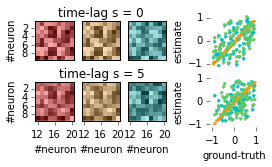

In [3]:
%matplotlib inline

fig_path =  '/home/mackelab/Desktop/Projects/Stitching/figures/'

#########################
# predicted covariances #
#########################

cmap = 'gray'
color_stitch = (244/255, 152/255,  25/255) #np.array((40,110,200))/255 #np.array((50,160,90))/255 
color_sp1    = 'c'
color_sp2    = np.array((100,200,100))/255 
color_data   = np.array((60,60,60))/255 #np.array((0,100,25))/255

lag_range = [0,5]
kl_ = np.max(lag_range) + 1

scale = 1
plt.figure(figsize=scale * np.array([4,len(lag_range)]))

i12 = np.setdiff1d(np.arange(p), obs_scheme.sub_pops[1])
i21 = np.setdiff1d(np.arange(p), obs_scheme.sub_pops[0])

for m in range(len(lag_range)):
    m_ = lag_range[m]
    
    clim = [np.inf, -np.inf]
    
    # ground-truth data covariances
    
    plt.subplot(len(lag_range),5,m*5+1)
    tmp = np.cov(y[np.ix_(np.arange(m_, T-kl_+m_),i12)].T, y[np.ix_(np.arange(T-kl_),i21)].T)[:len(i12),len(i21):]
    Qgt = tmp.copy()
    clim = [np.min((clim[0], tmp.min())), np.max((clim[1], tmp.max()))]
    plt.imshow(tmp, interpolation='None', cmap=cmap)
    plt.xticks([])
    plt.yticks([])
    #if m == 0:
    #    plt.title('data')
    if m == len(lag_range)-1:
        plt.xlabel('#neuron')
        plt.xticks(np.arange(0, len(i21), 4), i21[::4]+1)
    plt.ylabel('#neuron')
        
    plt.fill_between([-.5, len(i12)-.5], 
                     [-.5, -.5], 
                     [len(i21)-.5, len(i21)-.5],
                     edgecolor='r', 
                     where=None, facecolor='r', alpha=0.33)
    plt.yticks(np.arange(1, len(i12), 2), i12[::2]+2)
    plt.tick_params(axis="both", which="both", top="off", right="off", labelleft="on", tickdir='out')    


    # reconstructions from individually fitted subpopulations
    
    plt.subplot(len(lag_range),5,m*5+3)
    X = parss[0]['X'][m_*n:(m_+1)*n,:]
    C12, C21 = parss[0]['C'][:-2,:], -parss[1]['C'][2:,:]
    tmp = C12.dot(X).dot(C21.T)
    clim = [np.min((clim[0], tmp.min())), np.max((clim[1], tmp.max()))]
    plt.imshow(tmp, interpolation='None', cmap=cmap)
    plt.xticks([])
    #if m == 0:
    #    plt.title('subpopulations')
    if m == len(lag_range)-1:
        plt.xlabel('#neuron')
        plt.xticks(np.arange(0, len(i21), 4), i21[::4]+1)
    plt.fill_between([-.5, len(i12)-.5], 
                     [-.5, -.5], 
                     [len(i21)-.5, len(i21)-.5],
                     edgecolor=color_sp1, 
                     where=None, facecolor=color_sp1, alpha=0.33)
    plt.yticks([])
    plt.tick_params(axis="both", which="both", top="off", right="off", labelleft="on", tickdir='out')    

    plt.subplot(len(lag_range),4,(m+1)*4)
    plt.plot(Qgt.reshape(-1), tmp.reshape(-1), '.', color=color_sp1)


    # full-population reconstructions
    
    plt.subplot(len(lag_range),5,m*5+2)
    X = pars_est['X'][m_*n:(m_+1)*n,:]
    C12, C21 = pars_est['C'][i12,:], pars_est['C'][i21,:]
    tmp = C12.dot(X).dot(C21.T)
    clim = [np.min((clim[0], tmp.min())), np.max((clim[1], tmp.max()))]
    plt.imshow(tmp, interpolation='None', cmap=cmap)
    plt.xticks([])
    plt.yticks([])
    #if m == 0:
    #    plt.title('full-population')
    if m == len(lag_range)-1:
        plt.xlabel('#neuron')
        plt.xticks(np.arange(0, len(i21), 4), i21[::4]+1)
        
    plt.fill_between([-.5, len(i12)-.5], 
                     [-.5, -.5], 
                     [len(i21)-.5, len(i21)-.5],
                     edgecolor=color_stitch, 
                     where=None, facecolor=color_stitch, alpha=0.33)
    plt.tick_params(axis="both", which="both", top="off", right="off", labelleft="on", tickdir='out')    
    plt.title('time-lag s = ' + str(lag_range[m]))

    # finish scatter plot
    
    plt.subplot(len(lag_range),4,(m+1)*4)
    plt.plot(Qgt.reshape(-1), tmp.reshape(-1), '.', color=color_stitch)
    plt.axis([-1.1, 1.1, -1.1, 1.1])

    X = parss[1]['X'][m_*n:(m_+1)*n,:]
    C12, C21 = parss[0]['C'][:-2,:], -parss[1]['C'][2:,:]
    tmp = C12.dot(X).dot(C21.T)
    plt.plot(Qgt.reshape(-1), tmp.reshape(-1), '.', color=color_sp2)

    plt.tick_params(axis="both", which="both", top="off", right="off", labelleft="on", tickdir='out')    
    plt.box('off')
    
    plt.yticks([-1, 0, 1])
    plt.xticks([])
    if m == len(lag_range)-1:
        plt.xlabel('ground-truth')
        plt.xticks([-1, 0, 1])        
    plt.ylabel('estimate')


plt.savefig(fig_path + 'cov_predictions__transition_n3_oscillator.pdf')

plt.show()


In [ ]:
plt.figure(figsize=(10,6))

switch_time = 500

y_est   = np.zeros_like(y)
y_est12 = np.zeros_like(y)

idx_t = np.arange(y.shape[0]) #np.arange(obs_scheme.obs_time[0], dtype=int)
idx_i = np.setdiff1d(np.arange(p), obs_scheme.sub_pops[0])
idx = np.ix_(idx_t, idx_i)

y_est[idx] =   x_est[idx_t,:].dot(pars_est['C'][idx_i,:].T)
y_est12[idx] = x_est12[idx_t,:].dot(parss[1]['C'][2:,:].T)

idx_t = np.arange(y.shape[0]) #np.arange(obs_scheme.obs_time[0],y.shape[0]), dtype=int)
idx_i = np.setdiff1d(np.arange(p), obs_scheme.sub_pops[1])
idx = np.ix_(idx_t, idx_i)
y_est[idx] =   x_est[idx_t,:].dot(pars_est['C'][idx_i,:].T)
y_est12[idx] = x_est12[idx_t,:].dot(parss[0]['C'][:-2,:].T)

# select neurons for plotting
plot_idx_i = [[3,4,5], [3,4,5], [17,18,19], [17,18,19]]

dy = 6
for j in range(4):
    
    facecolor = 'g' if np.mod(j,2)==0 else 'c'
    color_sp  = color_sp1 if j < 2 else color_sp2    
    lw = 2 if j in [0,3] else 1.
    plot_range = np.arange(-switch_time, -0) if np.mod(j,2)==0 else np.arange(0, switch_time)
    plot_range += obs_scheme.obs_time[0]
    
    plt.subplot(2,2,j+1)
    
    for k in range(len(plot_idx_i[j])):    
        offset = (len(plot_idx_i[j])-1-k)*dy
        plt.plot(y[plot_range,plot_idx_i[j][k]] + offset,       color=np.array((200,200,200))/255, linewidth=0.9)
        plt.plot(y_est[plot_range,plot_idx_i[j][k]] + offset,   color=color_stitch,                linewidth=lw)
        plt.plot(y_est12[plot_range,plot_idx_i[j][k]] + offset, color=color_sp,                    linewidth=1)
        plt.hold(True)
    y_max, y_min = dy * (len(plot_idx_i[j])-1) + 3, -3
    plt.fill_between([0, len(plot_range)],
                     [y_min, y_min],
                     [y_max, y_max],
                     facecolor=facecolor, alpha=0.15)
    plt.xticks([0, switch_time//2, switch_time], 
               np.array([0, switch_time//2, switch_time]) + plot_range[0] - obs_scheme.obs_time[0])

    plt.yticks(np.arange(len(plot_idx_i[j]))[::-1] * dy, plot_idx_i[j])
    if j > 1:
        plt.xlabel('time relative to switch-point')
    if np.mod(j,2)==0: 
        plt.ylabel('#neuron')
    plt.axis([0, len(plot_range), y_min, y_max])
    plt.tick_params(axis="both", which="both", top="off", right="off", labelleft="on", tickdir='out')    
    plt.box('off')

plt.savefig(fig_path + 'predictions__transition_n3_oscillator.pdf')    
plt.show()


In [ ]:
plt.figure(figsize=(10,6))

switch_time = 500

y_est   = np.zeros_like(y)
y_est12 = np.zeros_like(y)

idx_t = np.arange(y.shape[0]) #np.arange(obs_scheme.obs_time[0], dtype=int)
idx_i = np.setdiff1d(np.arange(p), obs_scheme.sub_pops[0])
idx = np.ix_(idx_t, idx_i)

y_est[idx] =   x_est[idx_t,:].dot(pars_est['C'][idx_i,:].T)
y_est12[idx] = x_est12[idx_t,:].dot(parss[1]['C'][2:,:].T)

idx_t = np.arange(y.shape[0]) #np.arange(obs_scheme.obs_time[0],y.shape[0]), dtype=int)
idx_i = np.setdiff1d(np.arange(p), obs_scheme.sub_pops[1])
idx = np.ix_(idx_t, idx_i)
y_est[idx] =   x_est[idx_t,:].dot(pars_est['C'][idx_i,:].T)
y_est12[idx] = x_est12[idx_t,:].dot(parss[0]['C'][:-2,:].T)

# select neurons for plotting
plot_idx_i = [[3,12,13], [3,12,13], [19,24,29], [19,24,29]]

dy = 6
for j in range(4):
    
    facecolor = 'g' if np.mod(j,2)==0 else 'c'
    color_sp  = color_sp1 if j < 2 else color_sp2    
    lw = 2 if j in [0,3] else 1.
    plot_range = np.arange(-switch_time, -0) if np.mod(j,2)==0 else np.arange(0, switch_time)
    plot_range += obs_scheme.obs_time[0]
    
    for k in range(len(plot_idx_i[j])):    
        offset = (len(plot_idx_i[j])-1-k)*dy
        if j < 2: 
            offset += 3 * dy 
        plt.plot(plot_range, y[plot_range,plot_idx_i[j][k]] + offset,       color=np.array((200,200,200))/255, linewidth=0.9)
        plt.plot(plot_range, y_est[plot_range,plot_idx_i[j][k]] + offset,   color=color_stitch,                linewidth=lw)
        plt.plot(plot_range, y_est12[plot_range,plot_idx_i[j][k]] + offset, color=color_sp,                    linewidth=1)
        plt.hold(True)
    y_max, y_min = dy * (len(plot_idx_i[j])-1) + 3, -3
    
#plt.fill_between([plot_range[0], plot_range[1]],
#                 [y_min, y_min],
#                 [y_max, y_max],
#                 facecolor=facecolor, alpha=0.15)

plt.xticks([9750, 10000, 10250], [-250, 0, 250])
#plt.axis([0, len(plot_range), y_min, y_max])
plt.tick_params(axis="both", which="both", top="off", right="off", labelleft="on", tickdir='out')    
plt.box('off')

plt.xlabel('time relative to switch-point')
plt.ylabel('#neuron')

plot_idx_is = plot_idx_i[1] + plot_idx_i[2]
plt.yticks(np.arange(len(plot_idx_is))[::-1] * dy, plot_idx_is)
    
plt.savefig(fig_path + 'predictions__transition_n3_oscillator.pdf')    
plt.show()


In [ ]:
plt.imshow(y_est, interpolation='None', aspect='auto')
plt.show()